##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pix2Pix

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/alpha/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.

In example, we will use the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/), helpfully provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep our example short, we will use a preprocessed [copy](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/) of this dataset, created by the authors of the [paper](https://arxiv.org/abs/1611.07004) above.

Each epoch takes around 58 seconds on a single P100 GPU.

Below is the output generated after training the model for 200 epochs.

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Import TensorFlow and other libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

#~!pip install tensorflow-gpu==2.0.0-alpha0
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
from keras import backend as K

Using TensorFlow backend.


In [4]:
# config = K.tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.8
# K.set_session(K.tf.Session(config=config))

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8274172346532535869, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4242919929464473110
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5507202808823067331
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10979036365
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10088265700506927773
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1"]

## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.
* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [6]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
processed_image_folder_path = '/media/disk2/vefimova/kaist/processed/'
processed_image_folder_path_test = '/media/disk2/vefimova/kaist/processed_test/'
processed_image_arial_path = '/media/disk2/vefimova/icdar/ch2_processed_training_images_arial/'
processed_image_arial_path_small = processed_image_arial_path[:-1] + "_small/"

In [8]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

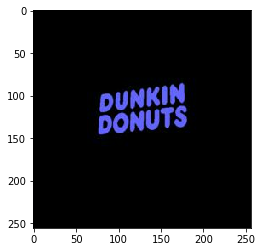

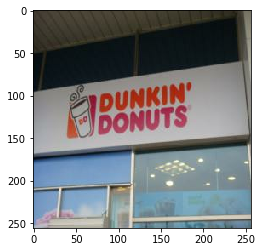

In [9]:
inp, re = load(processed_image_folder_path + 'DSC02690.JPG')
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [10]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [11]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [12]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [13]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

#     if tf.random.uniform(()) > 0.5:
#     # random mirroring
#         input_image = tf.image.flip_left_right(input_image)
#         real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

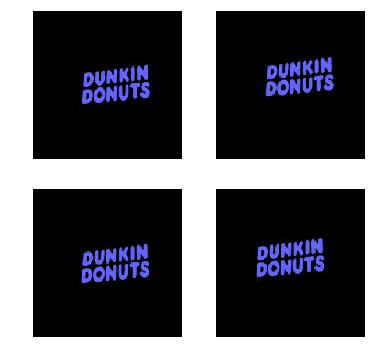

In [14]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [15]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [16]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## Input Pipeline

In [17]:
train_dataset = tf.data.Dataset.list_files(processed_image_folder_path + '*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

In [18]:
test_dataset = tf.data.Dataset.list_files(processed_image_folder_path_test + '*.jpg')
# shuffling so that for every epoch a different image is generated
# to predict and display the progress of our model.
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [19]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).



In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [25]:
import string

In [26]:
characters = '0123456789' + string.ascii_lowercase + '-'
label_classes = len(characters) + 1

In [57]:
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh', name="last") # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

  # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)
    
    # recognition part
    conv_1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    batchnorm_1 = tf.keras.layers.BatchNormalization()(conv_1)

    conv_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(batchnorm_1)
    conv_3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv_2)
    batchnorm_3 = tf.keras.layers.BatchNormalization()(conv_3)
    pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(batchnorm_3)

    conv_4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool_3)
    conv_5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv_4)
    batchnorm_5 = tf.keras.layers.BatchNormalization()(conv_5)
    pool_5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(batchnorm_5)

    conv_6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool_5)
    conv_7 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv_6)
    batchnorm_7 = tf.keras.layers.BatchNormalization()(conv_7)

    bn_shape = batchnorm_7.get_shape()
    print(bn_shape)
    
    x_reshape = tf.keras.layers.Reshape(target_shape=(int(bn_shape[1]), int(bn_shape[2] * bn_shape[3])))(batchnorm_7)

    fc_1 = tf.keras.layers.Dense(128, activation='relu')(x_reshape)  # (?, 50, 128)

    print(x_reshape.get_shape())  # (?, 50, 3584)
    print(fc_1.get_shape())  # (?, 50, 128)

    rnn_1 = tf.compat.v1.keras.layers.CuDNNLSTM(128, kernel_initializer="he_normal", return_sequences=True)(fc_1)
    rnn_1b = tf.compat.v1.keras.layers.CuDNNLSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(fc_1)
    rnn1_merged = tf.keras.layers.add([rnn_1, rnn_1b])

    rnn_2 = tf.compat.v1.keras.layers.CuDNNLSTM(128, kernel_initializer="he_normal", return_sequences=True)(rnn1_merged)
    rnn_2b = tf.compat.v1.keras.layers.CuDNNLSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(rnn1_merged)
    rnn2_merged = tf.keras.layers.concatenate([rnn_2, rnn_2b])

    drop_1 = tf.keras.layers.Dropout(0.25)(rnn2_merged)

    fc_2 = tf.keras.layers.Dense(label_classes, kernel_initializer='he_normal', activation='softmax')(drop_1)

    print(fc_2.get_shape())
    return tf.keras.Model(inputs=inputs, outputs=[x, fc_2])

(None, 64, 64, 512)
(None, 64, 32768)
(None, 64, 128)


W0419 17:05:30.166388 139798454961920 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(None, 64, 38)


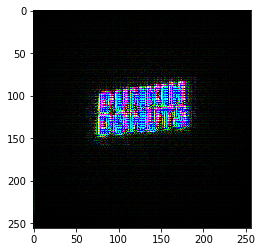

In [58]:
generator = Generator()

gen_output, recornition = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [29]:
print(tf.__version__)

2.0.0-alpha0


In [30]:
print(tf.keras.__version__)

2.2.4-tf


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [31]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

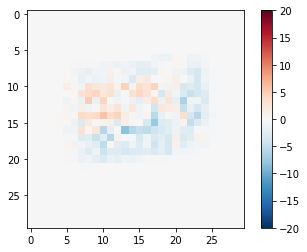

In [32]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

In [49]:
from keras import backend as bknd

In [50]:
LAMBDA = 100
MU = 100

In [51]:
ctc_decode = bknd.ctc_decode(["aaaa"], input_length=(1,))[0][0]
print(ctc_decode)
out = bknd.get_value(ctc_decode)[:, :label_len]

for m in range(1000):
    result_str = ''.join([characters[k] for k in out[m]])
    result_str = result_str.replace('-', '')

print(result_str)

AttributeError: module 'tensorflow' has no attribute 'log'

In [34]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [36]:
def generator_loss(disc_generated_output, gen_output, recognized, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    rec_loss = 0.0
    
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + MU * rec_loss

    return total_gen_loss

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints (Object-based saving)

In [38]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* This entire procedure is shown in the images below.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/images/dis.png?raw=1)


---


![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/images/gen.png?raw=1)

## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and **voila!**

In [39]:
EPOCHS = 500

In [40]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0][0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [41]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output, recognized = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, recognized, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [42]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [43]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for input_image, target in dataset:
            train_step(input_image, target)

        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

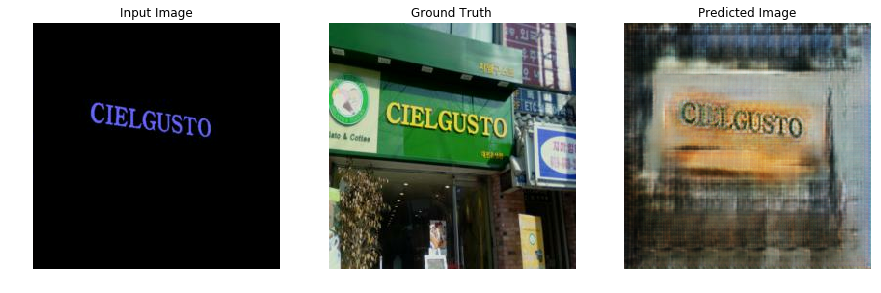

Time taken for epoch 1 is 21.07692003250122 sec



KeyboardInterrupt: 

In [44]:
train(train_dataset, EPOCHS)

## Restore the latest checkpoint and test

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Testing on the entire test dataset

In [ ]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset:
    generate_images(generator, inp, tar)

In [ ]:
print(type(generator))

In [ ]:
generator.summary()

In [ ]:
discriminator.summary()

In [ ]:
generator.save_weights("models/generator_londrina_200.h5")

In [ ]:
tf.keras.models.save_model(discriminator, "models/discriminator_londrina_200.h5")